Using data from jobs.ch will explore word2vec algorithm:

- Create a corpus from job descriptions
- Train the model
- Visualise embeddings using dimensionality reduction
- Find the most similar/closest words for a given word

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import re
from gensim.models import word2vec
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Read and prepare Data

In [2]:
df = pd.read_csv("job_ads_eng.csv", delimiter="," )
df.head()

Keywords                                 Job title  \
0   ICT System Engineer                           System Engineer   
1   Automation Engineer           Automation Engineer with DeltaV   
2  Development Engineer  Junior Development Engineer 100% (m/f/d)   
3      Contract Analyst             Contract & Commercial Manager   
4   Executive Assistant                 Executive Assistant 100 %   

        Date published          Alive until  \
0  2019-05-27 00:00:00  2019-06-05 00:00:00   
1  2019-04-23 00:00:00  2019-05-03 00:00:00   
2  2019-05-08 00:00:00  2019-05-24 00:00:00   
3  2019-06-14 00:00:00  2019-06-24 00:00:00   
4  2019-06-19 00:00:00  2019-06-24 00:00:00   

                         Company name       Location  \
0                      Harvey Nash AG         Zürich   
1     Spring Professional Engineering           Sion   
2              Zentra AG Ihr Jobprofi  Canton of Zug   
3  Huawei Technologies Switzerland AG   Dübendorf ZH   
4                          Habasit AG        Reinach   

                         Company type         Contract type Occupation  \
0                         Consultants  Unlimited employment        100   
1                         Consultants  Unlimited employment        100   
2                         Consultants  Unlimited employment  Temporary   
3             Large-scale entreprises  Unlimited employment        100   
4  Small and medium-sized enterprises  Unlimited employment        100   

                         Job rank  \
0                        Employee   
1  Position with responsibilities   
2  Position with responsibilities   
3  Position with responsibilities   
4                        Employee   

                                             Content  \
0  System EngineerJob Description   Overview of b...   
1  Ihre Herausforderung  You plan and implement A...   
2    Since 1989 - more than a quarter of a centur...   
3  Huawei is a leading global provider of informa...   
4  Executive Assistant 100 %Habasit is an interna...   

                           Industry                    Official website  \
0      Recruitment agency, Staffing        http://www.harveynash.com/ch   
1      Recruitment agency, Staffing  https://www.springprofessional.ch/   
2      Recruitment agency, Staffing                http://www.zentra.ch   
3  Information technology, Telecom.              http://www.huawei.com/   
4                  Industry various              http://www.habasit.com   

  Canton initials Canton name  
0              ZH      Zurich  
1              VS      Valais  
2              ZG         Zug  
3              ZH      Zurich  
4              BL       Basel

In [3]:
# removing unnecessary columns

df = df.drop(columns=['Keywords','Date published','Alive until','Company name','Location',
                      'Company type','Contract type','Occupation','Job rank','Industry', 'Official website','Canton initials','Canton name'], axis=1)

In [4]:
# removing web addresses and emails

df=df.replace(regex=r"\s(ag)\s", value='')
df=df.replace(regex=r"\s(xa)\s", value='')
df=df.replace(regex=r"[a-z]{4,5}\:\/\/\S{1,}", value="")
df=df.replace(regex=r"\S{1,}\@\S{1,}", value="")
df=df.apply(lambda col: col.str.lower())

In [5]:
# Creating corpus from job descriptions

text_corpus = df.values.tolist()

In [6]:
# Split each description into individual words and save everything in list of lists

def doc_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
sentences = list(doc_to_words(text_corpus))

# Checking the result

print(sentences[1])

['automation', 'engineer', 'with', 'deltav', 'ihre', 'herausforderung', 'you', 'plan', 'and', 'implement', 'automation', 'systems', 'for', 'pharmaceutical', 'production', 'you', 'develop', 'solutions', 'for', 'expansions', 'or', 'product', 'changes', 'and', 'optimize', 'the', 'automation', 'processes', 'accordingly', 'you', 'coordinate', 'and', 'monitor', 'the', 'control', 'system', 'with', 'regard', 'to', 'function', 'performance', 'costs', 'and', 'deadlines', 'you', 'have', 'full', 'responsibility', 'from', 'project', 'planning', 'till', 'commissioning', 'you', 'ensure', 'machine', 'safety', 'and', 'optimized', 'maintenance', 'you', 'supervise', 'and', 'support', 'an', 'team', 'of', 'engineers', 'automation', 'engineer', 'with', 'deltavihre', 'kompetenz', 'bsc', 'degree', 'in', 'electrical', 'engineering', 'automation', 'process', 'technology', 'or', 'relevant', 'educational', 'background', 'several', 'years', 'of', 'practical', 'experience', 'with', 'similar', 'tasks', 'as', 'automa

In [7]:
# Removing stopwords, adding more languages as there non-english descriptions.

stop_words = stopwords.words('english')
stop_words.extend(stopwords.words('german'))
stop_words.extend(stopwords.words('french'))
stop_words.extend(stopwords.words('italian'))

def remove_stopwords(text):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in text_corpus]
    
corpus = remove_stopwords(sentences)

In [8]:
len(corpus)

10000

# Creating Word2Vec model

In [9]:
# Create embeddings using word2vec

model = word2vec.Word2Vec(corpus, size=100, window=5, min_count=300, workers=4)



#model.wv['python']

## Visualizing embedings

In [10]:
# Plot the word corpus in a two dimensional plane using t-SNE dimensionality reduction

def tsne_plot(model):
    "Creates and t-SNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=500, n_components=2, init='pca', n_iter=2500, random_state=23 )
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

C:\Users\Andrius\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


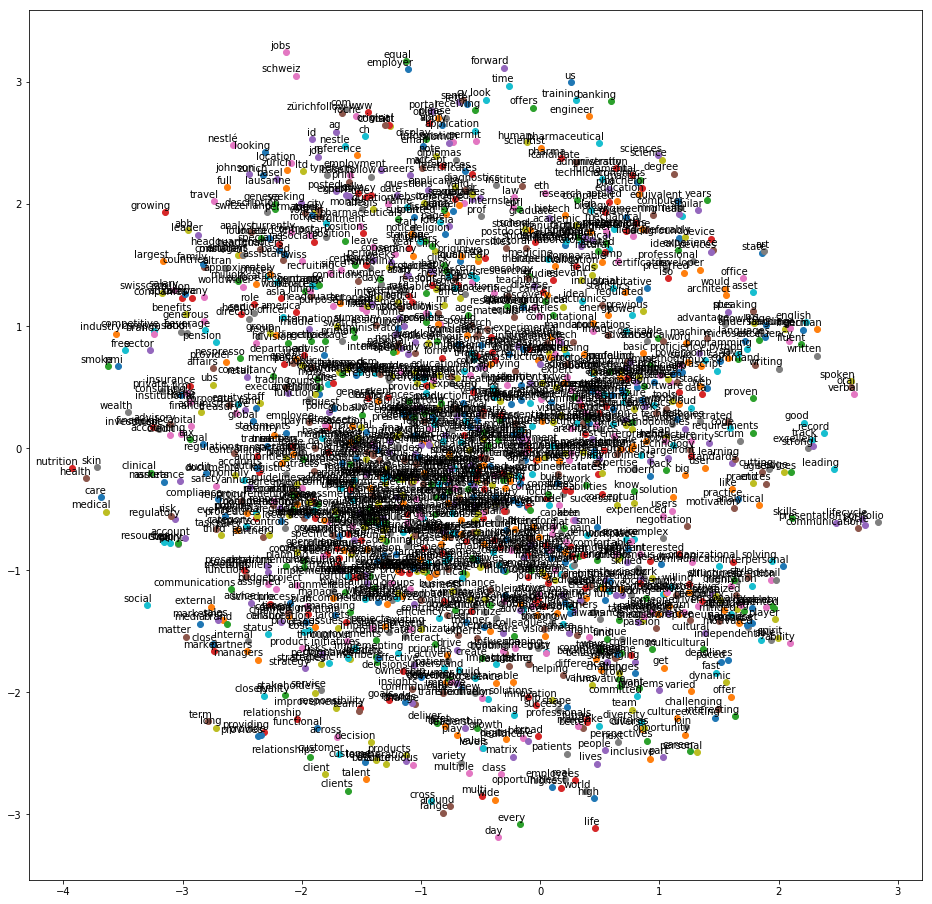

In [11]:
tsne_plot(model) 

Way too much data to see the word clusters clearly.

In [12]:
# Check the most similar/closest words to the given word

model.wv.most_similar(positive = ['java'], topn=100)

[('javascript', 0.8528046011924744),
 ('python', 0.8293184041976929),
 ('sql', 0.751555323600769),
 ('scripting', 0.7475031018257141),
 ('programming', 0.7395709753036499),
 ('backend', 0.7357385158538818),
 ('linux', 0.7054866552352905),
 ('oracle', 0.6861782073974609),
 ('rest', 0.641565203666687),
 ('aws', 0.6255100965499878),
 ('net', 0.6251009106636047),
 ('stack', 0.6065844297409058),
 ('web', 0.6016780138015747),
 ('server', 0.5913155674934387),
 ('software', 0.5778495669364929),
 ('developer', 0.5716290473937988),
 ('api', 0.5669881105422974),
 ('architectures', 0.5570224523544312),
 ('frameworks', 0.5548011064529419),
 ('windows', 0.5481061339378357),
 ('azure', 0.5464919805526733),
 ('nice', 0.5443918704986572),
 ('databases', 0.5147877931594849),
 ('devops', 0.5014208555221558),
 ('embedded', 0.49990126490592957),
 ('familiar', 0.48965537548065186),
 ('languages', 0.4884375035762787),
 ('native', 0.4775676131248474),
 ('mobile', 0.4528069794178009),
 ('distributed', 0.450371

In [13]:
def tsnescatterplot(model, word, list_names):
    
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']
    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word], topn=100)
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 100 to 10 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(15, 15)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 20,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
 
    
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(12)
            
    #plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    #plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    plt.show()

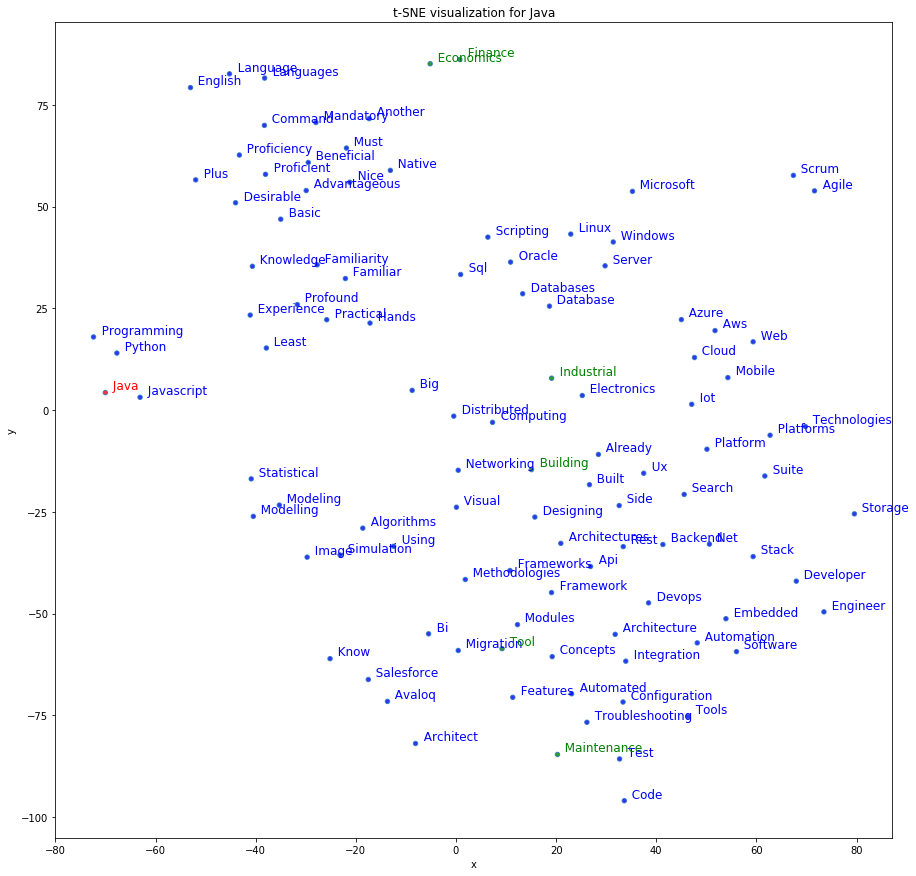

In [14]:
tsnescatterplot(model, 'java', ['finance', 'economics', 'maintenance', 'tool',
                                       'building', 'industrial'])

When looking at the 100 most similar words to the word "java", it is possible to see different clusters that represent specific topics withing this word context. 